# Automatic Differentiation
:label:`sec_autograd`

Recall from :numref:`sec_calculus`
that calculating derivatives is the crucial step
in all the optimization algorithms
that we will use to train deep networks.
While the calculations are straightforward,
working them out by hand can be tedious and error-prone,
and these issues only grow
as our models become more complex.

Fortunately all modern deep learning frameworks
take this work off our plates
by offering *automatic differentiation*
(often shortened to *autograd*).
As we pass data through each successive function,
the framework builds a *computational graph*
that tracks how each value depends on others.
To calculate derivatives,
automatic differentiation
works backwards through this graph
applying the chain rule.
The computational algorithm for applying the chain rule
in this fashion is called *backpropagation*.

While autograd libraries have become
a hot concern over the past decade,
they have a long history.
In fact the earliest references to autograd
date back over half of a century :cite:`Wengert.1964`.
The core ideas behind modern backpropagation
date to a PhD thesis from 1980 :cite:`Speelpenning.1980`
and were further developed in the late 1980s :cite:`Griewank.1989`.
While backpropagation has become the default method
for computing gradients, it is not the only option.
For instance, the Julia programming language employs
forward propagation :cite:`Revels.Lubin.Papamarkou.2016`.
Before exploring methods,
let's first master the autograd package.


In [ ]:
import torch

## A Simple Function

Let's assume that we are interested
in (**differentiating the function
$y = 2\mathbf{x}^{\top}\mathbf{x}$
with respect to the column vector $\mathbf{x}$.**)
To start, we assign `x` an initial value.


In [ ]:
x = torch.arange(4.0)
x

tensor([0., 1., 2., 3.])

[**Before we calculate the gradient
of $y$ with respect to $\mathbf{x}$,
we need a place to store it.**]
In general, we avoid allocating new memory
every time we take a derivative
because deep learning requires
successively computing derivatives
with respect to the same parameters
a great many times,
and we might risk running out of memory.
Note that the gradient of a scalar-valued function
with respect to a vector $\mathbf{x}$
is vector-valued with
the same shape as $\mathbf{x}$.


In [ ]:
# Can also create x = torch.arange(4.0, requires_grad=True)
x.requires_grad_(True)
x.grad  # The gradient is None by default

(**We now calculate our function of `x` and assign the result to `y`.**)


In [ ]:
y = 2 * torch.dot(x, x)
y

tensor(28., grad_fn=<MulBackward0>)

[**We can now take the gradient of `y`
with respect to `x`**] by calling
its `backward` method.
Next, we can access the gradient
via `x`'s `grad` attribute.


In [ ]:
y.backward()
x.grad

tensor([ 0.,  4.,  8., 12.])

(**We already know that the gradient of the function $y = 2\mathbf{x}^{\top}\mathbf{x}$
with respect to $\mathbf{x}$ should be $4\mathbf{x}$.**)
We can now verify that the automatic gradient computation
and the expected result are identical.


In [ ]:
x.grad == 4 * x

tensor([True, True, True, True])

[**Now let's calculate
another function of `x`
and take its gradient.**]
Note that PyTorch does not automatically
reset the gradient buffer
when we record a new gradient.
Instead, the new gradient
is added to the already-stored gradient.
This behavior comes in handy
when we want to optimize the sum
of multiple objective functions.
To reset the gradient buffer,
we can call `x.grad.zero_()` as follows:


In [ ]:
x.grad.zero_()  # Reset the gradient
y = x.sum()
y.backward()
x.grad

tensor([1., 1., 1., 1.])

## Backward for Non-Scalar Variables

When `y` is a vector,
the most natural representation
of the derivative of  `y`
with respect to a vector `x`
is a matrix called the *Jacobian*
that contains the partial derivatives
of each component of `y`
with respect to each component of `x`.
Likewise, for higher-order `y` and `x`,
the result of differentiation could be an even higher-order tensor.

While Jacobians do show up in some
advanced machine learning techniques,
more commonly we want to sum up
the gradients of each component of `y`
with respect to the full vector `x`,
yielding a vector of the same shape as `x`.
For example, we often have a vector
representing the value of our loss function
calculated separately for each example among
a *batch* of training examples.
Here, we just want to (**sum up the gradients
computed individually for each example**).


Because deep learning frameworks vary
in how they interpret gradients of
non-scalar tensors,
PyTorch takes some steps to avoid confusion.
Invoking `backward` on a non-scalar elicits an error
unless we tell PyTorch how to reduce the object to a scalar.
More formally, we need to provide some vector $\mathbf{v}$
such that `backward` will compute
$\mathbf{v}^\top \partial_{\mathbf{x}} \mathbf{y}$
rather than $\partial_{\mathbf{x}} \mathbf{y}$.
This next part may be confusing,
but for reasons that will become clear later,
this argument (representing $\mathbf{v}$) is named `gradient`.
For a more detailed description, see Yang Zhang's
[Medium post](https://zhang-yang.medium.com/the-gradient-argument-in-pytorchs-backward-function-explained-by-examples-68f266950c29).


In [ ]:
x.grad.zero_()
y = x * x
y.backward(gradient=torch.ones(len(y)))  # Faster: y.sum().backward()
x.grad

tensor([0., 2., 4., 6.])

## Detaching Computation

Sometimes, we wish to [**move some calculations
outside of the recorded computational graph.**]
For example, say that we use the input
to create some auxiliary intermediate terms
for which we do not want to compute a gradient.
In this case, we need to *detach*
the respective computational graph
from the final result.
The following toy example makes this clearer:
suppose we have `z = x * y` and `y = x * x`
but we want to focus on the *direct* influence of `x` on `z`
rather than the influence conveyed via `y`.
In this case, we can create a new variable `u`
that takes the same value as `y`
but whose *provenance* (how it was created)
has been wiped out.
Thus `u` has no ancestors in the graph
and gradients do not flow through `u` to `x`.
For example, taking the gradient of `z = x * u`
will yield the result `u`,
(not `3 * x * x` as you might have
expected since `z = x * x * x`).


In [ ]:
x.grad.zero_()
y = x * x
u = y.detach()
z = u * x

z.sum().backward()
x.grad == u

tensor([True, True, True, True])

Note that while this procedure
detaches `y`'s ancestors
from the graph leading to `z`,
the computational graph leading to `y`
persists and thus we can calculate
the gradient of `y` with respect to `x`.


In [ ]:
x.grad.zero_()
y.sum().backward()
x.grad == 2 * x

tensor([True, True, True, True])

## Gradients and Python Control Flow

So far we reviewed cases where the path from input to output
was well defined via a function such as `z = x * x * x`.
Programming offers us a lot more freedom in how we compute results.
For instance, we can make them depend on auxiliary variables
or condition choices on intermediate results.
One benefit of using automatic differentiation
is that [**even if**] building the computational graph of
(**a function required passing through a maze of Python control flow**)
(e.g., conditionals, loops, and arbitrary function calls),
(**we can still calculate the gradient of the resulting variable.**)
To illustrate this, consider the following code snippet where
the number of iterations of the `while` loop
and the evaluation of the `if` statement
both depend on the value of the input `a`.


In [ ]:
def f(a):
    b = a * 2
    while b.norm() < 1000:
        b = b * 2
    if b.sum() > 0:
        c = b
    else:
        c = 100 * b
    return c

Below, we call this function, passing in a random value, as input.
Since the input is a random variable,
we do not know what form
the computational graph will take.
However, whenever we execute `f(a)`
on a specific input, we realize
a specific computational graph
and can subsequently run `backward`.


In [ ]:
a = torch.randn(size=(), requires_grad=True)
d = f(a)
d.backward()

Even though our function `f` is, for demonstration purposes, a bit contrived,
its dependence on the input is quite simple:
it is a *linear* function of `a`
with piecewise defined scale.
As such, `f(a) / a` is a vector of constant entries
and, moreover, `f(a) / a` needs to match
the gradient of `f(a)` with respect to `a`.


In [ ]:
a.grad == d / a

tensor(True)

Dynamic control flow is very common in deep learning.
For instance, when processing text, the computational graph
depends on the length of the input.
In these cases, automatic differentiation
becomes vital for statistical modeling
since it is impossible to compute the gradient *a priori*.

## Discussion

You have now gotten a taste of the power of automatic differentiation.
The development of libraries for calculating derivatives
both automatically and efficiently
has been a massive productivity booster
for deep learning practitioners,
liberating them so they can focus on less menial.
Moreover, autograd lets us design massive models
for which pen and paper gradient computations
would be prohibitively time consuming.
Interestingly, while we use autograd to *optimize* models
(in a statistical sense)
the *optimization* of autograd libraries themselves
(in a computational sense)
is a rich subject
of vital interest to framework designers.
Here, tools from compilers and graph manipulation
are leveraged to compute results
in the most expedient and memory-efficient manner.

For now, try to remember these basics: (i) attach gradients to those variables with respect to which we desire derivatives; (ii) record the computation of the target value; (iii) execute the backpropagation function; and  (iv) access the resulting gradient.


## Exercises

1. Why is the second derivative much more expensive to compute than the first derivative?
1. After running the function for backpropagation, immediately run it again and see what happens. Investigate.
1. In the control flow example where we calculate the derivative of `d` with respect to `a`, what would happen if we changed the variable `a` to a random vector or a matrix? At this point, the result of the calculation `f(a)` is no longer a scalar. What happens to the result? How do we analyze this?
1. Let $f(x) = \sin(x)$. Plot the graph of $f$ and of its derivative $f'$. Do not exploit the fact that $f'(x) = \cos(x)$ but rather use automatic differentiation to get the result.
1. Let $f(x) = ((\log x^2) \cdot \sin x) + x^{-1}$. Write out a dependency graph tracing results from $x$ to $f(x)$.
1. Use the chain rule to compute the derivative $\frac{df}{dx}$ of the aforementioned function, placing each term on the dependency graph that you constructed previously.
1. Given the graph and the intermediate derivative results, you have a number of options when computing the gradient. Evaluate the result once starting from $x$ to $f$ and once from $f$ tracing back to $x$. The path from $x$ to $f$ is commonly known as *forward differentiation*, whereas the path from $f$ to $x$ is known as backward differentiation.
1. When might you want to use forward, and when backward, differentiation? Hint: consider the amount of intermediate data needed, the ability to parallelize steps, and the size of matrices and vectors involved.


[Discussions](https://discuss.d2l.ai/t/35)


In [ ]:
#  为什么计算二阶导数比一阶导数成本更高？
# 计算复杂度角度：一阶导数是基于函数值的变化率直接计算，例如对于函数 \(y = f(x)\)，根据导数定义 \(f^\prime(x)=\lim_{h\rightarrow0}\frac{f(x + h)-f(x)}{h}\) ，只需要对函数在 x 和 \(x + h\) 处取值并做简单运算。而二阶导数是一阶导数的导数，即 \(f^{\prime\prime}(x)=(f^\prime(x))^\prime\) 。要计算二阶导数，首先得算出一阶导数的表达式（这本身可能就涉及复杂函数求导规则应用），然后再对一阶导数表达式重复求导过程，相当于多了一轮求导运算，涉及更多函数求值、极限计算等操作，计算步骤和运算量显著增加。数值计算角度：在数值计算中，计算一阶导数时，用有限差分近似（如中心差分 \(\frac{f(x + h)-f(x - h)}{2h}\) ），只需要对函数在少数几个临近点取值。计算二阶导数时，比如用中心差分近似二阶导数 \(\frac{f(x + h)-2f(x)+f(x - h)}{h^2}\) ，需要更多点的函数值，并且计算中涉及更多乘法、减法等运算，在处理大规模数据或复杂函数时，计算量会大幅上升。

In [10]:
import torch
import time

# 定义一个函数，例如 f(x) = x^3
def f(x):
    return x ** 3

# 定义 x 并开启梯度计算
x = torch.tensor(2.0, requires_grad=True)

# 计算一阶导数并记录时间
start_time_1 = time.time()
y = f(x)
y.backward(retain_graph=True)
first_derivative = x.grad
end_time_1 = time.time()
time_1 = end_time_1 - start_time_1
print(f"一阶导数: {first_derivative}，计算时间: {time_1} 秒")

# 计算二阶导数并记录时间
start_time_2 = time.time()
# 为了计算二阶导数，需要对一阶导数再次求导
x.grad.zero_()  # 清除之前的梯度
y.backward(retain_graph=True)
second_derivative = torch.autograd.grad(y, x, create_graph=True)[0].grad
end_time_2 = time.time()
time_2 = end_time_2 - start_time_2
print(f"二阶导数: {second_derivative}，计算时间: {time_2} 秒")

# 输出时间差异
print(f"二阶导数计算时间比一阶导数多: {time_2 - time_1} 秒")

一阶导数: 12.0，计算时间: 0.0009648799896240234 秒
二阶导数: None，计算时间: 0.0015490055084228516 秒
二阶导数计算时间比一阶导数多: 0.0005841255187988281 秒


<ipython-input-10-6b77187bf4ec>:25: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /pytorch/build/aten/src/ATen/core/TensorBody.h:489.)
  second_derivative = torch.autograd.grad(y, x, create_graph=True)[0].grad


In [11]:
import torch

# 定义一个简单的线性模型
x = torch.tensor([1.0], requires_grad=True)
y = torch.tensor([2.0])
w = torch.tensor([3.0], requires_grad=True)

# 前向传播
y_pred = x * w
# 定义损失函数
loss = (y_pred - y) ** 2

# 第一次反向传播
loss.backward(retain_graph=True)
print(f"第一次反向传播后 w 的梯度: {w.grad}")

# 第二次反向传播
loss.backward()
print(f"第二次反向传播后 w 的梯度: {w.grad}")


第一次反向传播后 w 的梯度: tensor([2.])
第二次反向传播后 w 的梯度: tensor([4.])


In [12]:
import torch

# 将 a 定义为随机向量
a = torch.randn(3, requires_grad=True)
# 定义函数 f(a)，这里简单定义为 f(a) = sum(a^2)
f = torch.sum(a ** 2)
# 反向传播计算梯度
f.backward()
# 输出梯度
print(f"f 关于 a 的梯度: {a.grad}")


f 关于 a 的梯度: tensor([-1.7256,  0.7366,  2.3061])


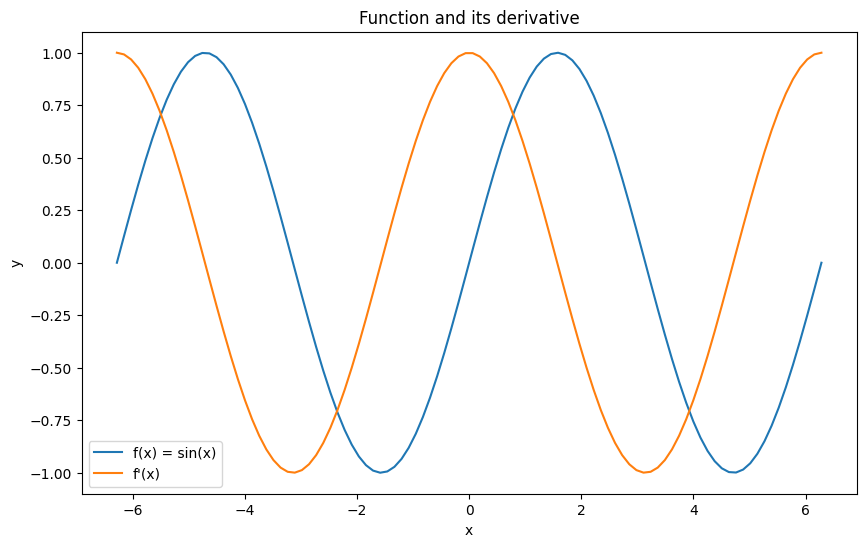

In [14]:
import torch
import matplotlib.pyplot as plt

# 生成 x 值
x = torch.linspace(-2 * torch.pi, 2 * torch.pi, 100, requires_grad=True)
# 定义函数 f(x) = sin(x)
y = torch.sin(x)
# 计算导数
y.backward(torch.ones_like(x))
# 获取导数
dy_dx = x.grad

# 绘制函数及其导数的图像
plt.figure(figsize=(10, 6))
plt.plot(x.detach().numpy(), y.detach().numpy(), label='f(x) = sin(x)')
plt.plot(x.detach().numpy(), dy_dx.detach().numpy(), label="f'(x)")
plt.xlabel('x')
plt.ylabel('y')
plt.title('Function and its derivative')
plt.legend()
plt.show()


In [16]:
from graphviz import Digraph

# 创建有向图
dot = Digraph(comment='Dependency Graph for f(x)=((log x^2)*sin x)+x^(-1)')

# 添加节点
dot.node('x', 'x')
dot.node('u', 'u = x^2')
dot.node('v', 'v = log(u)')
dot.node('w', 'w = sin(x)')
dot.node('y', 'y = v * w')
dot.node('z', 'z = x^(-1)')
dot.node('f(x)', 'f(x) = y + z')

# 添加边
dot.edges([('x', 'u'), ('u', 'v'), ('x', 'w'), ('v', 'y'), ('w', 'y'), ('x', 'z'), ('y', 'f(x)'), ('z', 'f(x)')])

# 渲染图形
dot.render('dependency_graph.gv', view=True)


'dependency_graph.gv.pdf'

In [17]:
import torch

# 定义 x 并开启梯度计算
x = torch.tensor(2.0, requires_grad=True)
# 计算中间变量
u = x ** 2
v = torch.log(u)
w = torch.sin(x)
y = v * w
z = x ** (-1)
# 计算 f(x)
f = y + z
# 反向传播计算梯度
f.backward()
# 输出导数
print(f"导数 df/dx: {x.grad}")


导数 df/dx: 0.08239537477493286


In [ ]:
# 7. 给定图和中间导数结果，在计算梯度时你有多种选择。分别从 x 到 f 和从 f 追溯到 x 计算结果。从 x 到 f 的路径通常称为前向差分，而从 f 到 x 的路径称为反向差分。前向差分（从 x 到 f ）：按照函数的计算顺序，从输入 x 开始，逐步计算中间变量的值，同时根据求导规则计算每个中间步骤的导数。例如对于 \(f(x)=((\log x^{2})\cdot\sin x)+x^{-1}\) ，先计算 \(u = x^{2}\) ，\(v=\log u\) 等中间变量，在计算过程中依据链式法则依次求出 \(\frac{dv}{dx}\) 、\(\frac{dw}{dx}\) 等，最后根据加法法则和乘积法则得到 \(\frac{df}{dx}\) 。这种方法对于每个变量都要完整计算其导数，当变量很多时，计算量会随着变量数量增加而显著增大，因为每个变量的导数计算都相对独立且要完整进行。反向差分（从 f 到 x ）：从输出 \(f(x)\) 开始，利用链式法则反向追溯计算梯度。对于复杂的函数或神经网络，它可以复用中间计算结果，减少不必要的重复计算。例如在神经网络中，许多神经元的计算存在共享部分，反向传播（反向差分）可以通过一次从输出到输入的遍历，高效地计算出所有参数的梯度。对于上述函数 \(f(x)\) ，从 \(f(x)\) 开始，先根据加法法则将梯度分配到 y 和 z ，再分别对 y 和 z 根据其组成部分反向追溯计算梯度，能更高效地利用已有的中间导数信息 。8. 何时你可能希望使用前向差分，何时使用反向差分？提示：考虑所需中间数据量、步骤并行化能力以及涉及的矩阵和向量的大小。前向差分适用场景：简单函数或变量较少时：当函数结构简单，变量数量不多时，前向差分计算相对直接，不需要维护复杂的反向计算图，计算过程清晰易懂，不容易出错。例如对于简单的多项式函数求导，直接按照求导规则从前向后计算导数较为方便。需要并行计算多个变量导数时：如果有强大的并行计算资源，并且需要同时计算多个变量的导数，前向差分可以在不同变量的计算上进行并行处理。因为每个变量的导数计算相对独立，在硬件支持下可以同时对多个变量进行求导计算，加速整体计算过程。反向差分适用场景：深度学习和复杂函数计算：在深度学习中，神经网络结构复杂，参数众多。反向差分（反向传播）可以高效地计算损失函数关于大量参数的梯度。通过复用中间层的计算结果，避免了很多重复计算，大大减少了计算量。例如在训练一个多层神经网络时，反向传播能快速计算出每一层参数的梯度用于更新参数。涉及大量中间变量和共享计算时：当函数包含大量中间变量，且存在很多共享计算部分时，反向差分能更好地利用这些共享信息。比如在一些复杂的数值模拟函数中，不同部分的计算可能依赖相同的中间变量，反向差分可以从输出端反向追溯，按需计算导数，减少计算资源浪费 。